In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00


In [2]:
#1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import json
from collections import OrderedDict
from sklearn.metrics import accuracy_score
import os
from transformers import AutoTokenizer
import math
from sklearn.metrics import accuracy_score ,f1_score ,recall_score ,classification_report


In [3]:
#2
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#3
n_epochs=10
win_size=40

In [5]:
#4
path="drive/MyDrive/NLP_2023/HW1"
checkpoint_path="drive/MyDrive/NLP_2023/HW1/checkpoints"

In [6]:
#4_1
os.makedirs(checkpoint_path,exist_ok=True)

**Read JSON file and after that gives us the data frame as a data, and at the end return it.**

Then we read train data and test data from the following .jsonl file

In [7]:
#5
def read_json (file_path):
    l=[]
    data=open(file_path)
    for line in data :
        l.append(json.loads(line))
    data=pd.DataFrame(l)
    return(data)

train_data=read_json(f"{path}/data/train.jsonl")
test_data=read_json(f"{path}/data/test.jsonl")


In [8]:
#6
train_data

,idx,tokens,labels
0,0,"[Hard, Rock, Hell, III, :, The, Vikings, Ball, .]","[O, O, O, O, O, O, O, O, O]"
1,1,"[Casualties, and, damage, were, severe, on, bo...","[B-SCENARIO, O, B-CHANGE, O, O, O, O, O, O, O,..."
2,2,"[This, incident, led, to, violence, in, Al, An...","[O, B-SENTIMENT, B-CHANGE, I-CHANGE, B-ACTION,..."
3,3,"[As, of, 2016, ,, aspects, of, the, crisis, in...","[O, O, O, O, O, O, O, B-SCENARIO, O, O, O, O, ..."
4,4,"[the, depression, tracked, northwestward, ,, i...","[O, O, B-ACTION, O, O, B-CHANGE, O, O, B-SCENA..."
...,...,...,...
19995,19995,"[A, combined, Byzantine-Crusader, siege, of, D...","[O, B-CHANGE, O, B-ACTION, O, O, B-POSSESSION,..."
19996,19996,"[Additional, rebels, poured, into, the, town, .]","[O, O, B-ACTION, O, O, O, O]"
19997,19997,"[Edna, transitioned, into, an, extratropical, ...","[O, B-CHANGE, O, O, O, O, O, O, O, O, O, O, B-..."
19998,19998,"[As, a, result, ,, multiple, center, relocatio...","[O, O, O, O, O, O, O, B-CHANGE, O, O, O, O, O, O]"


In [9]:
#7
unique_lable=np.unique(np.hstack(train_data.labels))
l_labels=len(unique_lable)


lable_dict=OrderedDict(zip(unique_lable,range(0,l_labels+1)))
lable_dict["pad"]=11


We have 11 unique lables and we represent length of unique lables on the l_lables.

In [10]:
#8
train_data.labels=train_data.labels.apply(lambda x: [x[i*win_size:(i+1)*win_size] for i in range(math.ceil(len(x)/win_size))])
train_data.labels=train_data.labels.apply(lambda x : [i+(win_size-len(i))*["pad"] for i in x])
train_data.tokens=train_data.tokens.apply(lambda x: [x[i*win_size:(i+1)*win_size] for i in range(math.ceil(len(x)/win_size))])
train_data.tokens=train_data.tokens.apply(lambda x : [i+(win_size-len(i))*["<pad>"] for i in x])

train_lbl=np.vstack(train_data.labels.values)
train_tkn=np.vstack(train_data.tokens.values)
print(train_tkn.shape)

(22267, 40)


Then we set lable_dict to determine the lables as a dictionary to use or change them whenever it is needed. Furthermore, we can get the values of each key that is available in the dictionary. It receives key (i) and for the output it returns its values.

For each lables we execute change_lables which is the function we determine previously. It transform lable column to the numbers in order to use them in the model. Because we cannot call the string on the model. Every single of these numbers are represantative of each strings.

In [11]:
#9
test_data.labels=test_data.labels.apply(lambda x: [x[i*win_size:(i+1)*win_size] for i in range(math.ceil(len(x)/win_size))])
test_data.labels=test_data.labels.apply(lambda x : [i+(win_size-len(i))*["pad"] for i in x])
test_data.tokens=test_data.tokens.apply(lambda x: [x[i*win_size:(i+1)*win_size] for i in range(math.ceil(len(x)/win_size))])
test_data.tokens=test_data.tokens.apply(lambda x :[i+(win_size-len(i))*["<pad>"] for i in x])
test_lbl=np.vstack(test_data.labels.values)
test_tkn=np.vstack(test_data.tokens.values)

I consider for each token(t) which is available in our list (x), make lower case of the word's characters, so it doesn't allow to use the upper case characters. The reason is preventing repeated counting in tokenise section.

In [12]:
#10
train_lbl=np.vectorize(lambda x :lable_dict[x])(train_lbl)
test_lbl=np.vectorize(lambda x :lable_dict[x])(test_lbl)

In [13]:
#11
train_tkn=np.vectorize(lambda x :x.lower())(train_tkn)
test_tkn=np.vectorize(lambda x :x.lower())(test_tkn)

Then here calculate the length of tokens to analyse how much token does it have which is unique. It is equal to the number of unique token in train_dataset, and its numbers in test_dataset as well. So, we attach them together, and we recognize how much unique is there.

In [14]:
#12
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_tkn=np.vectorize(lambda x :tokenizer.convert_tokens_to_ids(x))(train_tkn)
test_tkn=np.vectorize(lambda x :tokenizer.convert_tokens_to_ids(x))(test_tkn)

Then I put the lable Encoder to allocate some numbers to these lables. (To use them in the model).

Then fit it in our data set.
Finally, transform it in the dataset.For each of x , transform is executed.
After that we receive np.array that should be transformed to the torch.tensor. I did it for both test_dataset, and train_dataset.

In [15]:
#13
train_dataloder=DataLoader(TensorDataset(torch.tensor(train_tkn),torch.tensor(train_lbl)),batch_size=128)
test_dataset=TensorDataset(torch.tensor(test_tkn),torch.tensor(test_lbl))

In [16]:
#14
class costum_model(nn.Module):
    def __init__(self,input_size):
        super(costum_model,self).__init__()
        self.embed=nn.Embedding(input_size, 32)
        self.RNN=nn.LSTM(32, 12, 2 )
        self.dropout=nn.Dropout(.2)


    def forward(self,x):
        x=self.embed(x)
        x=self.RNN(x)[0]
        x=self.dropout(x)
        x=torch.softmax(x,2)
        x=torch.permute(x,(0,2,1))
        return x

Here obtained maximum length of string. Due to our string should have equality in length.Output of lables, and input of x should be equal. There will be error if the lenghts are not equal together.
Then I set the padding on it. In tensorflow we can set the size, but we cannot do the same in torch. So, I make an empty padding as long as the maximum length, then at the end we remove our first record , for have padding length as same as that.

In torch with regards to the maximum length, dit will execute the padding.

In [17]:
#15
model=costum_model(30000)
criterion=nn.CrossEntropyLoss(ignore_index=11)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(n_epochs):
    for step,(inputs,lbls) in enumerate(train_dataloder):
        pred=model(inputs)
        loss=criterion(pred,lbls)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        r_pred=torch.argmax(pred,1).reshape(-1)
        r_lbl=lbls.reshape(-1)
        r_lbl=r_lbl[torch.where(r_lbl !=11)[0]]
        r_pred=r_pred[torch.where(r_lbl !=11)[0]]

        acc=accuracy_score(r_lbl,r_pred)
        f1=f1_score(r_lbl,r_pred,average='weighted')
        print (f"epoch: {epoch} , step: {step} , loss : {loss.item()} , accuracy: {round(acc,2)} , f1_score: {f1}")
torch.save(model,f"./{checkpoint_path}/model{epoch}.pth")

epoch: 0 , step: 0 , loss : 2.4784603118896484 , accuracy: 0.16 , f1_score: 0.26978335880901216
epoch: 0 , step: 1 , loss : 2.4771554470062256 , accuracy: 0.18 , f1_score: 0.29366807382446275
epoch: 0 , step: 2 , loss : 2.476313352584839 , accuracy: 0.23 , f1_score: 0.3627734028880058
epoch: 0 , step: 3 , loss : 2.474832057952881 , accuracy: 0.27 , f1_score: 0.40377698530341216
epoch: 0 , step: 4 , loss : 2.47393536567688 , accuracy: 0.33 , f1_score: 0.4643376317401056
epoch: 0 , step: 5 , loss : 2.4725375175476074 , accuracy: 0.36 , f1_score: 0.4992289600392983
epoch: 0 , step: 6 , loss : 2.4709606170654297 , accuracy: 0.38 , f1_score: 0.5209127559717586
epoch: 0 , step: 7 , loss : 2.470153331756592 , accuracy: 0.45 , f1_score: 0.5769793861686118
epoch: 0 , step: 8 , loss : 2.4686777591705322 , accuracy: 0.47 , f1_score: 0.5941167559548098
epoch: 0 , step: 9 , loss : 2.467507839202881 , accuracy: 0.6 , f1_score: 0.685721407290026
epoch: 0 , step: 10 , loss : 2.465705633163452 , accura

In [18]:
#16
t_pred=np.array([])
t_lbl=np.array([])
for index in range(len(test_dataset)):
    test_input,test_lbl=test_dataset.__getitem__(index)

    test_pred=model(torch.unsqueeze(test_input,0))
    test_pred=torch.squeeze(torch.argmax(test_pred,1))

    rt_lbl=test_lbl[torch.where(test_lbl !=11)[0]]
    rt_pred=test_pred[torch.where(test_lbl !=11)[0]]

    t_pred=np.hstack((t_pred,rt_pred.detach().numpy()))
    t_lbl=np.hstack((t_lbl,rt_lbl.detach().numpy()))




In [19]:
#17
test_acc=accuracy_score(t_lbl,t_pred)
test_recall=recall_score(t_lbl,t_pred,average='weighted')
test_f1=f1_score(t_lbl,t_pred,average='weighted')

In [20]:
#18
print(f"test accuracy: {test_acc}")
print(f"test recall: {test_recall}")
print(f"test f1_score: {test_f1}")


print (classification_report(t_lbl,t_pred))

test accuracy: 0.7475444702242846
test recall: 0.7475444702242846
test f1_score: 0.7822818703060788
              precision    recall  f1-score   support

         0.0       0.05      0.04      0.04      2257
         1.0       0.03      0.04      0.03      1303
         2.0       0.01      0.04      0.01       275
         3.0       0.01      0.01      0.01       629
         4.0       0.01      0.02      0.01       319
         5.0       0.00      0.00      0.00        50
         6.0       0.00      0.00      0.00        62
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.02      0.01        47
         9.0       0.00      0.00      0.00         2
        10.0       0.90      0.82      0.86     46775

    accuracy                           0.75     51720
   macro avg       0.09      0.09      0.09     51720
weighted avg       0.82      0.75      0.78     51720



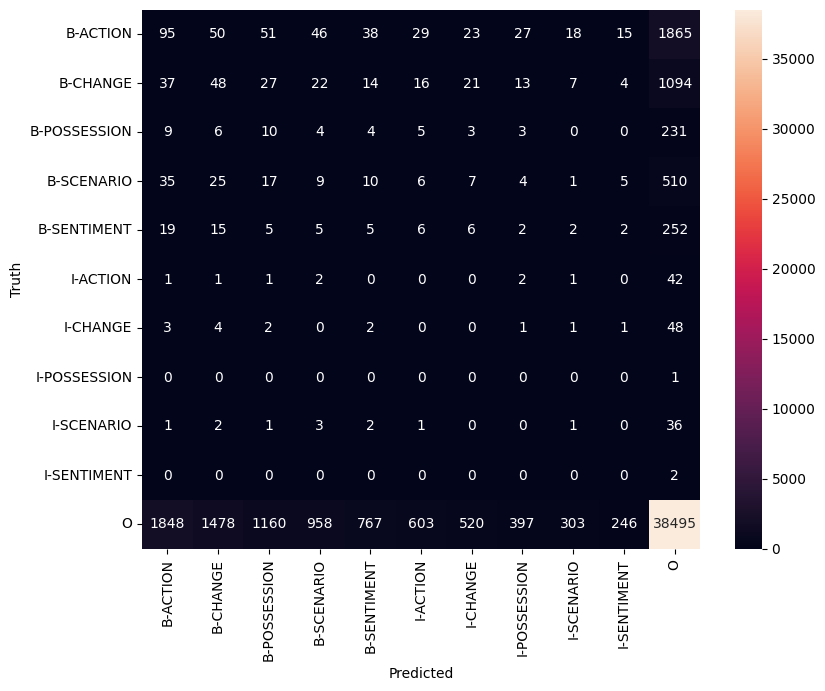

In [21]:
#19
def plot_confusion_matrix(true,pred):
    fig,ax=plt.subplots(figsize = (9,7))
    key=list(lable_dict.keys())
    key.remove("pad")
    sns.heatmap(confusion_matrix(true,pred),
                yticklabels=key,
                xticklabels=key,
                annot=True, fmt='d')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    fig.show()

plot_confusion_matrix(t_lbl,t_pred)